In [1]:
# physical_devices = tf.config.experimental.list_physical_devices('GPU')
# print("Num GPUs Available: ", len(physical_devices))
# tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [2]:
import os
import time
from datetime import datetime

import numpy as np
import pandas as pd
import scipy
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import tensorflow as tf
#from tensorflow import keras #I think this package produces a discrepency between val_loss and val_metric (where both are MAE)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense
import tensorflow.keras.optimizers
import tensorflow.keras.metrics


np.set_printoptions(precision=5, suppress=True)
pd.set_option("display.precision", 2)

In [3]:
data_file_path = os.path.join(os.getcwd(), "Data\YX.csv")
RData = pd.read_csv(data_file_path)
finalData=RData


# finalData = dataset.map(..., num_parallel_calls=10)
# finalData = dataset.prefetch(buffer_size)

In [4]:
# import dask.dataframe
# finalData = dask.dataframe.read_csv(data_file_path)
# finalData
#finalData.dtypes

# trainY = finalData["returns"][0:20].compute()
# trainY
# trainX = finalData.loc[:, finalData.columns != "returns"]
# trainX


In [5]:
descrNames = ["gvkey", "fdateYQ", "Split"] + ["MktCap"]
dummyNames = ["loc", "Sector", "acctstdq", "compstq"] # "bsprq", "scfq", "staltq",
detailedDummyNames = ["city", "Subsector", "IndustryGroup", "Industry", "NationalIndustry"]
dependentNames = ["returns", "volatility",
                  "2Classes", "4Classes", "6Classes", "8Classes", "10Classes",
                  "Simple2Classes", "Simple4Classes", "Simple6Classes", "Simple8Classes", "Simple10Classes"]

dontNormalizeCols = dependentNames + descrNames + dummyNames + detailedDummyNames
dontCreateRatio = ["TimeDifferenceInDays",
                   "quarterlyReturns-1", "quarterlyReturns-2", "quarterlyReturns-3", "quarterlyReturns-4",
                   "quarterlyVolatility-1",  "quarterlyVolatility-2", "quarterlyVolatility-3", "quarterlyVolatility-4",
                   "past2YearReturn", "past3YearReturn", "past4YearReturn", "past5YearReturn",
                   "past2YearVolatility", "past3YearVolatility", "past4YearVolatility", "past5YearVolatility"]

numCols = finalData.columns.difference(dontNormalizeCols).to_list()
ratioCols = finalData.columns.difference(dontNormalizeCols + dontCreateRatio).to_list()

#finalData[factorCols] = finalData[factorCols].astype("category")
#finalData[numCols] = finalData[numCols].astype('float32')
#finalData[numCols] = finalData[numCols].astype('int32')


#finalData["fdateq"] = pd.to_datetime(finalData["fdateq"], format = "%Y%m%d")
#finalData["datadate"] = pd.to_datetime(finalData["datadate"], format = "%Y%m%d")
#finalData["fdateYQ"] = pd.to_datetime(finalData["fdateYQ"], format = "%Y%q") #check quarter format


In [6]:
#xLogData = finalData[numCols].apply(lambda x: np.log(x+0.001))
finalData[numCols].apply(lambda x: (min(x), max(x)))
# plt.hist(xLogData, bins=1000)
# plt.show()

,TimeDifferenceInDays,accdq,acoq,acoxq,actq,ancq,aoq,apq,atq,capsq,...,revtq,saleq,sctq,seqq,teqq,txtq,xintq,xoproq,xoprq,xsgaq
0,9,-1.64e+03,-1.92e+04,-1.93e+04,8.97e-01,6.32e-01,1.35e-01,-1.64e+03,8.18e+00,-9.42e+05,...,-2.92e+06,-2.92e+06,1.00e-03,-5.88e+06,-7.09e+06,-1.52e+06,-1.10e+04,-2.58e+04,-3.60e+06,-8.31e+01
1,99,2.75e+07,4.21e+07,4.21e+07,1.75e+08,2.35e+08,1.48e+08,4.05e+07,3.93e+08,2.45e+07,...,8.44e+07,8.44e+07,4.47e+07,1.84e+08,2.32e+08,5.31e+06,1.73e+06,8.23e+06,8.42e+07,5.47e+06


In [7]:
finalData.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57843 entries, 0 to 57842
Data columns (total 97 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   gvkey                  57843 non-null  int64  
 1   fdateYQ                57843 non-null  float64
 2   returns                57843 non-null  float64
 3   volatility             57843 non-null  float64
 4   MktCap                 57843 non-null  float64
 5   Split                  57843 non-null  object 
 6   TimeDifferenceInDays   57843 non-null  int64  
 7   loc                    57843 non-null  object 
 8   city                   57842 non-null  object 
 9   acctstdq               57842 non-null  object 
 10  compstq                17378 non-null  object 
 11  Sector                 57843 non-null  int64  
 12  Subsector              57843 non-null  int64  
 13  IndustryGroup          57843 non-null  int64  
 14  Industry               57843 non-null  int64  
 15  Na

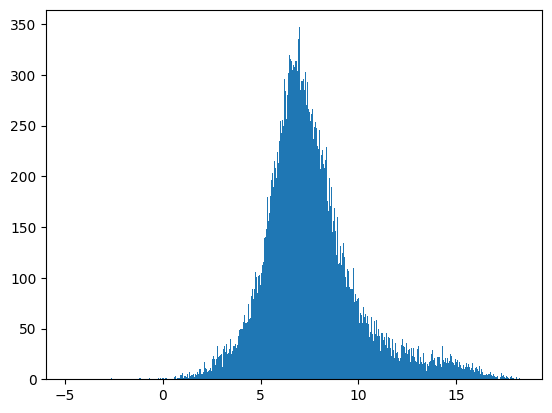

In [8]:
#xLogData = xRatioData["revtq"]
xLogData = finalData["revtq"].apply(lambda x: np.log(x+0.0001))

import matplotlib.pyplot as plt

plt.hist(xLogData, bins=1000)
plt.show()

In [9]:
#Ratio data
ratioData = finalData.copy()
ratioData[ratioCols] = finalData[ratioCols].div(finalData["MktCap"].values, axis=0) #This is an inplace operation if copy() is not used
#ratioData[ratioCols] = finalData[ratioCols].apply(lambda x: x/finalData["MktCap"].values, axis=0)



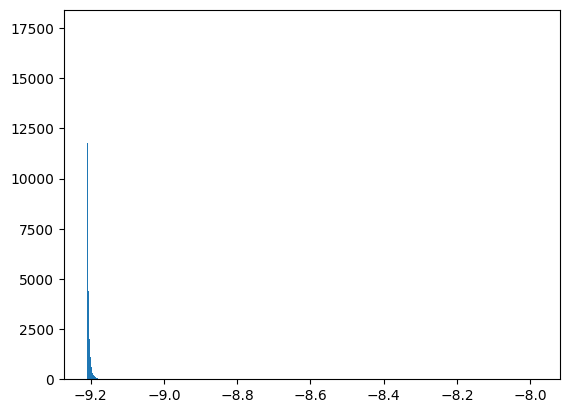

In [10]:
#import math
#xLogData = math.log(ratioData["returns"])
#xLogData = np.log(ratioData["returns"] + 105)
#xLogData = np.log1p(ratioData["returns"]/105)
#xLogData = ratioData[numCols].apply(lambda x: np.log(x), axis=1)
#xLogData = ratioData["revtq"]
xLogData = ratioData["revtq"].apply(lambda x: np.log(x+0.0001))

import matplotlib.pyplot as plt
plt.hist(xLogData, bins=1000)
plt.show()

In [11]:
#Winsorised data
import scipy

winData=ratioData.copy()
winData[numCols] = ratioData[numCols].apply(lambda x: scipy.stats.mstats.winsorize(x, limits = (0.01, 0.01))) #This is an inplace operation if copy() is not used
#Should we winsorize and scale the dependent variable?

In [12]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
#scaler = MinMaxScaler(feature_range=(0, 1))
scaler = StandardScaler()

#My scaling and winsorizing is biased. They should be done based on the training data, not testing and validation
scaledData=winData.copy() 
scaledData[numCols] = scaler.fit_transform(scaledData[numCols]) #This is an inplace operation if copy() is not used


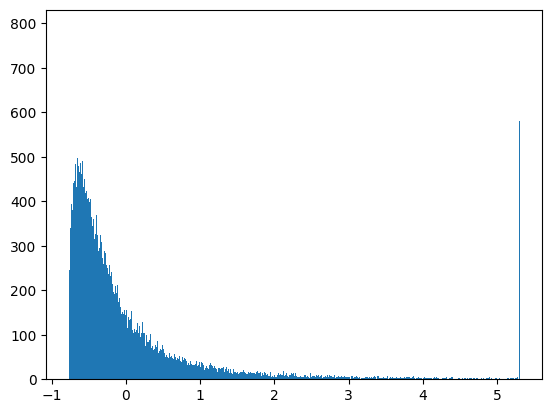

In [13]:
xLogData = scaledData["revtq"].apply(lambda x: np.log(x)) 
#xLogData = xScaledData["revtq"].apply(lambda x: np.log(x+0.005)) 
import matplotlib.pyplot as plt

#plt.hist(xLogData, bins=100)
plt.hist(scaledData["revtq"], bins=1000)
plt.show()

In [14]:
#xScaledData
scaledData.describe().to_csv("Descr//FinalizedDesc.csv")
scaledData.describe().to_html("Descr//FinalizedDesc.html")
scaledData.describe()



,gvkey,fdateYQ,returns,volatility,MktCap,TimeDifferenceInDays,Sector,Subsector,IndustryGroup,Industry,...,2Classes,4Classes,6Classes,8Classes,10Classes,Simple2Classes,Simple4Classes,Simple6Classes,Simple8Classes,Simple10Classes
count,57843.00,57843.00,5.78e+04,57843.00,5.78e+04,5.78e+04,57843.00,57843.00,57843.00,57843.00,...,57843.0,57843.00,57843.00,57843.00,57843.00,57843.0,57843.00,57843.00,57843.0,57843.00
mean,249188.33,2018.04,2.34e+00,0.36,1.42e+12,-2.22e-16,35.94,362.10,3316.14,27112.46,...,1.5,2.50,3.50,4.50,5.49,0.5,1.00,1.00,1.0,1.00
std,55481.86,3.42,2.20e+01,0.20,1.57e+13,1.00e+00,11.73,118.48,1543.70,19273.53,...,0.5,1.12,1.71,2.29,2.87,0.5,0.71,0.58,0.5,0.45
min,1166.00,2009.75,-9.41e+01,0.00,1.42e+05,-1.85e+00,11.00,11.00,11.00,11.00,...,1.0,1.00,1.00,1.00,1.00,0.0,0.00,0.00,0.0,0.00
25%,213376.00,2015.75,-9.04e+00,0.23,2.42e+09,-7.57e-01,32.00,325.00,3222.00,3344.00,...,1.0,1.00,2.00,2.00,3.00,0.0,0.00,1.00,1.0,1.00
50%,260034.00,2018.75,-2.22e-14,0.32,6.71e+09,-2.78e-02,33.00,333.00,3333.00,32731.00,...,1.0,2.00,3.00,4.00,5.00,0.0,1.00,1.00,1.0,1.00
75%,287313.00,2021.00,9.81e+00,0.44,2.26e+10,7.01e-01,33.00,336.00,3363.00,33451.00,...,2.0,3.00,5.00,6.00,8.00,1.0,1.00,1.00,1.0,1.00
max,341563.00,2022.50,9.22e+02,16.79,5.56e+14,2.00e+00,99.00,999.00,9999.00,99998.00,...,2.0,4.00,6.00,8.00,10.00,1.0,2.00,2.00,2.0,2.00


In [15]:
# #tf.sparse.SparseTensor
# import tensorflow as tf
# from tensorflow import keras

# np.set_printoptions(precision=3, suppress=True)
# ###tf.enable_eager_execution()
# #tf.keras.Model.run_eagerly

# dataset = tf.data.experimental.make_csv_dataset(
#     data_file_path, label_name="returns", batch_size=2, num_epochs=1,
#     shuffle=False, sloppy=True) # compression_type = GZIP #ZLIB
# iterator = dataset.as_numpy_iterator()

# #dataset.zip()
# #dataset
# #iterator.next()

# # for batch, label in dataset.take(1):
# #   for key, value in batch.items():
# #     print(f"{key:20s}: {value}")
# #   print()
# #   print(f"{'label':20s}: {label}")

# #b = dataset.map(lambda x: x*2)


# dummyLayer = tf.keras.layers.StringLookup(
#     mask_token=None,
#     encoding="utf-8",
#     output_mode="one_hot",
#     sparse=True
# )

# # dummyDataset = dataset.map(lambda x, y: (
# #     {n: x[n] for n in numCols} | {f: dummyLayer.adapt(x[f]) for f in factorCols},
# #     y))



# # feature_ds = dataset.map(lambda x, y: x[name])
# # feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))
# # # Learn the set of possible string values and assign them a fixed integer index
# # lookup.adapt(feature_ds)



# #dummyDataset = dataset.map(lambda x, y: ({f: x[f] for f in factorCols}))
# #dummyDataset = dataset.map(lambda x, y: (x[f] for f in factorCols))
# #dummyDataset = dataset.map(lambda x, y: x[factorCols])
# #dummyDataset = dataset.map(lambda x, y: x["loc"])

# #dummyDataset.batch(32)

# #d = dummyLayer.adapt(dummyDataset)


# from sklearn.preprocessing import OneHotEncoder
# ohe = OneHotEncoder(categories='auto', sparse=False)
# # ohe.fit_transform(dataset[['loc']])

# dummyDataset = dataset.map(lambda x, y: ({f: ohe.fit_transform(x[f]) for f in factorCols}))


# from sklearn.preprocessing import LabelEncoder
# le = LabelEncoder()
# le.fit_transform(df['col1'])
# dictionary_length = len(le.classes_)



# #from sklearn.model_selection import TimeSeriesSplit
# #tscv = TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None)



# # dummyLayer = tf.keras.layers.StringLookup(
# #     mask_token=None,
# #     encoding="utf-8",
# #     output_mode="int"
# # )

# # dummyDataset = dataset.map(lambda x, y: (
# #     {n: x[n] for n in numCols} | {f: dummyLayer(x[f]) for f in factorCols},
# #     y))


# # for batch, label in dummyDataset.take(1):
# #   for key, value in batch.items():
# #     print(f"{key:20s}: {value}")
# #     print()
# #     print(f"{'label':20s}: {label}")



# # embeddedDummies = tf.keras.layers.Embedding(
# #     input_dim=2000,
# #     output_dim=10,
# #     activity_regularizer=None,
# #     mask_zero=True,
# # )

# # dummyModel = tf.keras.Sequential()
# # dummyModel.add(embeddedDummies)

# # with tf.device('cpu:0'):
# #   embedding_layer = Embedding(...)
# #   embedding_layer.build()


In [16]:
dummyData = pd.get_dummies(scaledData, dummy_na=False, sparse=False, drop_first=False,
                         columns=dummyNames)#, "bsprq", "scfq", "staltq"])


target = ["Simple2Classes"]
Y = scaledData[target + ["Split"]]

if target != ["returns"] and target != ["volatility"]:
    Y = pd.get_dummies(dummyData[target + ["Split"]], dummy_na=False, sparse=False, drop_first=False,
                       columns=target)

#Y = np.asarray(Y).astype('float32')
yTrain, yVal, yTest = Y[Y["Split"]=="Train"].drop(["Split"], axis=1), Y[Y["Split"]=="Validation"].drop(["Split"], axis=1) , Y[Y["Split"]=="Test"].drop(["Split"], axis=1)

X = pd.get_dummies(scaledData[numCols + dummyNames + ["Split"]], dummy_na=False, sparse=False, drop_first=False,
                         columns=dummyNames)#, "bsprq", "scfq", "staltq"])

xTrain, xVal, xTest = X.loc[X["Split"]=="Train"].drop(["Split"], axis=1), X.loc[X["Split"]=="Validation"].drop(["Split"], axis=1), X.loc[X["Split"]=="Test"].drop(["Split"], axis=1)


In [17]:
# catEncodingLayer = tf.keras.layers.CategoryEncoding(
#     num_tokens=3, output_mode="one_hot", sparse=False
# )

# catEncodingLayer(xScaledData[["2Classes"]])



In [18]:
# intLookupLayer = tf.keras.layers.IntegerLookup(
#     max_tokens=3,
#     num_oov_indices=1,
#     mask_token=None,
#     vocabulary=[1,10],
#     output_mode="one_hot",
#     sparse=False,
#     pad_to_max_tokens=False
# )

# #intLookupLayer.adapt(xScaledData[["10Classes"]])
# intLookupLayer(xScaledData[["10Classes"]])


In [19]:
# pd.DataFrame.to_csv(dummies, "Data/dummiesData.csv", index=False)
# #dummies.to_hdf(r"Data/dummiesData2.csv", key='dummies', mode='w')

namesOfAllPredictorsAndDummies = list(X.columns)
X.info(verbose=True)
#dummies.info(verbose=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57843 entries, 0 to 57842
Data columns (total 174 columns):
 #    Column                 Dtype  
---   ------                 -----  
 0    TimeDifferenceInDays   float64
 1    accdq                  float64
 2    acoq                   float64
 3    acoxq                  float64
 4    actq                   float64
 5    ancq                   float64
 6    aoq                    float64
 7    apq                    float64
 8    atq                    float64
 9    capsq                  float64
 10   ceqq                   float64
 11   cheq                   float64
 12   cogsq                  float64
 13   cstkq                  float64
 14   dfxaq                  float64
 15   dlcq                   float64
 16   dlttq                  float64
 17   dpq                    float64
 18   eqrtq                  float64
 19   eroq                   float64
 20   gpq                    float64
 21   ibmiiq                 float64
 2

In [20]:
# import tensorflow as tf
# from tensorflow import keras

# np.set_printoptions(precision=3, suppress=True)
# ###tf.enable_eager_execution()
# #tf.keras.Model.run_eagerly

# #xScaledDataWithDummies = pd.concat([xScaledData, dummies], axis=1) 


# #numeric_dict_ds = tf.data.Dataset.from_tensor_slices((dict(numeric_features), target))
# categorical_feature_names = factorCols
# binary_feature_names = []

# inputs = {}
# for name, column in xScaledData.items():
#   if type(column[0]) == str:
#     dtype = tf.string
#   elif (name in categorical_feature_names or
#         name in binary_feature_names):
#     dtype = tf.int64
#   else:
#     dtype = tf.float32

#   inputs[name] = tf.keras.Input(shape=(), name=name, dtype=dtype)


# preprocessed = []
# for name in categorical_feature_names:
#   vocab = sorted(set(xScaledData[name]))
#   #print(f'name: {name}')
#   #print(f'vocab: {vocab}\n')

#   if type(vocab[0]) is str:
#     lookup = tf.keras.layers.StringLookup(vocabulary=vocab, output_mode='one_hot')
#   else:
#     lookup = tf.keras.layers.IntegerLookup(vocabulary=vocab, output_mode='one_hot')

#   x = inputs[name][:, tf.newaxis]
#   x = lookup(x)
#   preprocessed.append(x)


# numeric_feature_names = numCols

# def stack_dict(inputs, fun=tf.stack):
#     values = []
#     for key in sorted(inputs.keys()):
#       values.append(tf.cast(inputs[key], tf.float32))

#     return fun(values, axis=-1)
# #normalizer = tf.keras.layers.Normalization(axis=-1)
# #normalizer.adapt(numeric_features)

# numeric_inputs = {}
# for name in numeric_feature_names:
#   numeric_inputs[name]=inputs[name]

# numeric_inputs = stack_dict(numeric_inputs)
# #numeric_normalized = normalizer(numeric_inputs)

# #preprocessed.append(numeric_normalized)
# preprocessed.append(numeric_inputs)
# #preprocessed

# preprocessed_result = tf.concat(preprocessed, axis=-1)
# #preprocessed_result

# preprocessor = tf.keras.Model(inputs, preprocessed_result)

# tf.keras.utils.plot_model(preprocessor, rankdir="LR", show_shapes=True)

# preprocessor(dict(xScaledData.iloc[:1]))

# xWinTrainDict, xWinValDict, xWinTestDict = xScaledData.loc[split=="Train", :], xScaledData.loc[split=="Validation", :], xScaledData.loc[split=="Test", :]
# xWinTrainDict, xWinValDict, xWinTestDict = dict(xWinTrainDict), dict(xWinValDict), dict(xWinTestDict)
# xWinTrainDict, xWinValDict, xWinTestDict = preprocessor(xWinTrainDict), preprocessor(xWinValDict), preprocessor(xWinTestDict)


# # dataset = tf.data.experimental.make_csv_dataset(xScaledDataWithDummies, label_name="returns", batch_size=2, num_epochs=1,
# #     shuffle=False, sloppy=True) # compression_type = GZIP #ZLIB
# # iterator = dataset.as_numpy_iterator()


# # inputs = {}
# # for name, column in df.items():
# #   if type(column[0]) == str:
# #     dtype = tf.string
# #   elif (name in categorical_feature_names or
# #         name in binary_feature_names):
# #     dtype = tf.int64
# #   else:
# #     dtype = tf.float32

# #   inputs[name] = tf.keras.Input(shape=(), name=name, dtype=dtype)


In [21]:
# physical_devices = tf.config.experimental.list_physical_devices('GPU')
# print("Num GPUs Available: ", len(physical_devices))
# tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [23]:
def NNfunction(modelType, layers, units, activation, dropout, L1, L2, batch_size, optimizer, learning_rate, runningDate):
    
    performCV = False
    verbose = 1
    patience = 1
    epochs = 300
    numberOfOutputs = yTrain.shape[1]

    classification = False
    finalActivation = "linear"
    loss = "MeanAbsoluteError"   # 'tf.keras.losses.MeanSquaredError()'  #Huber #MeanAbsoluteError #MeanSquaredError 
    metrics = ["MeanAbsoluteError", "MeanSquaredError"] #, "RootMeanSquaredError"]) #accuracy #MeanSquaredLogarithmicError #RootMeanSquaredError #MeanAbsolutePercentageError 
    EarlyStopping_monitor = "val_mean_absolute_error"

    if target != ["returns"] and target != ["volatility"] and target != ["returns", "volatility"]:
        classification = True
        finalActivation = "softmax"
        loss = "categorical_crossentropy"
        metrics = ["accuracy"]
        EarlyStopping_monitor = "val_loss"
    
    
    # Adam(learning_rate=0.0001) #RMSprop #sgd
    if optimizer == "RMSprop":
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
    elif optimizer == "Adam":
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    else:
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)


    #input1 = tf.keras.layers.Input(shape=(1,))
    #input2 = tf.keras.layers.Input(shape=(1,))
    #merged = tf.keras.layers.Concatenate(axis=1)([input1, input2])
    #dense1 = tf.keras.layers.Dense(2, input_dim=2, activation=keras.activations.sigmoid, use_bias=True)(merged)

    input = tf.keras.layers.Input(shape=(xTrain.shape[1],))
    #model.add(tf.keras.layers.BatchNormalization())

    if modelType == "LSTM":
        hidden = tf.keras.layers.LSTM(units=units[0])(input)
    elif modelType == "GRU":
        hidden = tf.keras.layers.GRU(units=units[0])(input)
    elif modelType == "SimpleRNN":
        hidden = tf.keras.layers.SimpleRNN(units=units[0])(input)
    elif modelType == "FeedForward":
        denseLayer = tf.keras.layers.Dense(units=units[0],
                            activation=activation,
                            kernel_regularizer=tf.keras.regularizers.L1L2(l1=L1, l2=L2))
        dropOutLayer = tf.keras.layers.Dropout(rate=dropout)

        try:
            hidden = denseLayer(input)
            hidden = dropOutLayer(hidden)
            for n in range(1, layers):
                hidden = tf.keras.layers.Dense(units=units[n],
                            activation=activation,
                            kernel_regularizer=tf.keras.regularizers.L1L2(l1=L1, l2=L2))(hidden)
                hidden = dropOutLayer(hidden)
                # scaler.fit_transform
                # tf.keras.layers.BatchNormalization(
            print(f"NN{layers}Layer")
        except Exception as e: 
            print(e)
            print("NN1Layer_WhyDidWeEndUpHere?")


    outputLayer = tf.keras.layers.Dense(units=numberOfOutputs, activation=finalActivation,
                                        kernel_regularizer=tf.keras.regularizers.L1L2(l1=L1, l2=L2))

    if modelType == "RegularizedLinear" or modelType == "StandardLinear":
        output = outputLayer(input)
        print("Linear")
    # elif modelType == "StandardLinear":
    #     output = outputLayer(input)
    #     print("StandardLinear")
    else:
        output = outputLayer(hidden)

    #model = tf.keras.models.Model(inputs=[input1, input2], output=output)
    model = tf.keras.models.Model(inputs=[input], outputs=output, name=f"{modelType}_{runningDate}")

    model.compile(optimizer=optimizer,
                loss=loss,
                metrics=metrics)


    loss_and_metrics_matrix = pd.DataFrame()
    epochs_matrix = pd.DataFrame()
    quarters = dummyData[dummyData["Split"] == "Validation"]["fdateYQ"].unique()
    quarters.sort()
    if performCV:    
        for q in quarters:
            # Run cross validation through model fit and evaluate. 
            # Save all MSAs and MSEs from "loss_and_metrics" into a dataframe and take their average to obtain the best model
            print("Quarter " + str(q))
            xT = dummyData[dummyData["fdateYQ"] < q].drop(descrNames + dependentNames + detailedDummyNames, axis=1)
            yT = dummyData[dummyData["fdateYQ"] < q][target]
            #A rolling window might be faster. E.g.: dummies["fdateYQ"] == q - 0.25

            xV = dummyData[dummyData["fdateYQ"] == q].drop(descrNames + dependentNames + detailedDummyNames, axis=1)
            yV = dummyData[dummyData["fdateYQ"] == q][target]

            if target != ["returns"] and target != ["volatility"]:
                yT = pd.get_dummies(yT, dummy_na=False, sparse=False, drop_first=False,
                            columns=target)
                yV = pd.get_dummies(yV, dummy_na=False, sparse=False, drop_first=False,
                            columns=target)
                

            earlystopping_callback = tf.keras.callbacks.EarlyStopping(
                    monitor=EarlyStopping_monitor, patience=patience, verbose=1, restore_best_weights=True) #Can this be taken out from the loop? => Less computing

            # tensorboardLogPath = f"Results/logs/{runningDate}/{modelType}_{layers}L_{units}U_{activation}_{dropout}DO_{L1}L1_{L2}L2_{batch_size}Batch_{optimizer._name}_{learning_rate}LR_Q{q}"
            # tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=tensorboardLogPath) #tensorboard --logdir="10-01-2023_1606" #tensorboard --logdir="logs/"
            #BackupAndRestore_callback = tf.keras.callbacks.BackupAndRestore(backup_dir="/tmp/backup")

            history = model.fit(x=xT, y=yT,
                                batch_size=batch_size, epochs=epochs,
                                callbacks=[earlystopping_callback], verbose=verbose, validation_data=(xV, yV))

            loss_and_metrics = model.evaluate(xV, yV, batch_size=batch_size, return_dict=True)
            epochs_EarlyStopping = len(history.history['loss']) - patience

            loss_and_metrics = pd.DataFrame(loss_and_metrics, index=[q])
            loss_and_metrics_matrix = pd.concat((loss_and_metrics_matrix, loss_and_metrics))

            epochs_EarlyStopping = pd.DataFrame({"Epochs": epochs_EarlyStopping}, index=loss_and_metrics.index)
            epochs_matrix = pd.concat((epochs_matrix, epochs_EarlyStopping))
        print(pd.concat((loss_and_metrics_matrix, epochs_matrix), ignore_index=False, axis=1), "\n")

        loss_and_metrics = loss_and_metrics_matrix.mean()
        loss_and_metrics = loss_and_metrics.to_dict()
        epochs_EarlyStopping = epochs_matrix.mean()[0]

    else:
        earlystopping_callback = tf.keras.callbacks.EarlyStopping(
                    monitor=EarlyStopping_monitor, patience=patience, verbose=1, restore_best_weights=True) #Can this be taken out from the loop? => Less computing

        tensorboardLogPath = f"Results/logs/{runningDate}/{modelType}_{layers}L_{units}U_{activation}_{dropout}DO_{L1}L1_{L2}L2_{batch_size}Batch_{optimizer._name}_{learning_rate}LR"
        tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=tensorboardLogPath) #tensorboard --logdir="10-01-2023_1606" #tensorboard --logdir="logs/"
        #BackupAndRestore_callback = tf.keras.callbacks.BackupAndRestore(backup_dir="/tmp/backup")
        history = model.fit(x=xTrain, y=yTrain,
                batch_size=batch_size, epochs=epochs,
                callbacks=[earlystopping_callback, tensorboard_callback], verbose=verbose, validation_data = (xVal, yVal))
        loss_and_metrics = model.evaluate(xVal, yVal, batch_size=batch_size, return_dict=True)
        epochs_EarlyStopping = len(history.history['loss']) - patience
        print(loss_and_metrics, "\n", epochs_EarlyStopping, "\n")
        #history.history[]

    # history = model.fit(x=xWinTrainDict, y=yTrain,
    #           batch_size=16, epochs=300,
    #           callbacks=[callback], verbose=1, validation_data = (xWinValDict, yVal))


    # quarters = len(yVal)
    # CV = []
    # for q in range(0, quarters):

    #     model.fit(x=xTrain, y=yTrain,
    #           batch_size=16, epochs=epo, verbose=2)

    #     validationError = model.evaluate(xVal, yVal, batch_size=128)
    #     CV = [CV, validationError]


    # try:
    #     loss_and_metrics = [x for x in loss_and_metrics]
    # except:     
    #     print(loss_and_metrics)

    # return loss_and_metrics, model, epochs_EarlyStopping
    return loss_and_metrics, epochs_EarlyStopping, model

    #model.predict(xVal, batch_size=128)



In [24]:
from itertools import chain, combinations, permutations
def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    res = chain.from_iterable(permutations(s, r) for r in range(1, len(s)+1))
    return res

In [25]:
# hiddenUnits = 2**np.arange(9)
# #random.sample([hiddenUnits], 5, 2)

# hiddenUnitsGrid = np.random.choice(hiddenUnits, size=(1000, max(hiddenLayers)), replace=True, p=None)

# #hiddenUnitsGrid = np.random.choice([1,2,3], size=(25, 3), replace=True, p=None)

# hiddenUnitsGrid

# len(set(map(tuple, hiddenUnitsGrid.tolist())))

# hiddenUnitsGrid = list(powerset(hiddenUnits))
# #hiddenUnitsGrid = list(powerset([1,2,4,8,16,32]))

# #np.random.Generator.choice(hiddenUnits, size=(25, 3), replace=True, p=None)

# #random.choices(population=hiddenUnits, weights=None, cum_weights=None, k=5)


# #hiddenUnitsGrid = list(itertools.product(hiddenUnits, repeat=max(hiddenLayers)))


NameError: name 'hiddenLayers' is not defined

In [26]:
import itertools
import random
import pandas as pd

#Hyper-Parameters
NNModelType = {"FeedForward"} #, "LSTM", "GRU"}
hiddenLayers = {1, 2, 3, 4, 5}
hiddenUnits = 2**np.arange(9)
#hiddenUnitsGrid = list(itertools.product(hiddenUnits, repeat=max(hiddenLayers)))
#hiddenUnitsGrid = random.sample(population = hiddenUnits, k=max(hiddenLayers), counts=10)
hiddenUnitsGrid = random.sample(list(itertools.product(hiddenUnits, repeat=max(hiddenLayers))), k=50)

activationFunc = {"linear", "relu", "sigmoid", "tanh"} #etc. https://keras.io/api/layers/activations/ , "selu"
dropOut = np.arange(start=0, stop=1, step=0.1)
#epochs = [100] #Just choose best model. => Run for 100 epochs, but if 20th epoch is the best, choose it, i.e. early stopping
#inputSize = numberOfVariables #ncol(trainXPools[[1]])
#other parameters: loss func, node structure, location of the regularization function
batchSize = 2**np.arange(start=4, stop=9)
optim = {"Adam", "RMSprop"}#, "sgd"}
learningRate = {0.01, 0.001, 0.0001}#, 0.00001}
L1L2Grid = 10**np.arange(start=2, stop=-6, step=-1.0) #3 and -10
L1L2Grid = np.append(0, L1L2Grid)
none = {None}
zero = {0}

StandardLinearParams = {
    "Model type": {"StandardLinear"},
    "Hidden layers": zero,
    "Hidden units": zero,
    "Activation function": none,
    "Dropout": zero,
    "L1": {0.0},
    "L2": {0.0},
    "Batch size": {32},
    "Optimizer": {"Adam"},
    "Learning rate": {0.001}
}

LinearParams = StandardLinearParams | {
    "Model type": {"RegularizedLinear"},
    "L1": L1L2Grid,
    "L2": L1L2Grid,
    "Batch size": batchSize,
    "Optimizer": optim,
    "Learning rate": learningRate
}

NNParams = LinearParams | {
    "Model type": NNModelType,  # , "LSTM", "GRU"},
    "Hidden layers": hiddenLayers,
    "Hidden units": hiddenUnitsGrid,
    "Activation function": activationFunc,
    "Dropout": dropOut
}

NaiveZeroParams = StandardLinearParams | {
    "Model type": {"NaiveZeroForecast"},
    "Batch size": none,
    "Optimizer": none,
    "Learning rate": none,
    "Epochs": none,
    "Training Time (minutes)": none,
    "ModelPointer": none
}

NaiveMeanParams = NaiveZeroParams | {"Model type": {"NaiveMeanForecast"}}
NaiveFirmMeanParams = NaiveZeroParams| {"Model type": {"NaiveFirmMeanForecast"}}
NaiveFiveYearParams = NaiveZeroParams| {"Model type": {"NaiveFiveYearForecast"}}

StandardLinearGrid = pd.DataFrame(itertools.product(
    *StandardLinearParams.values()), columns=StandardLinearParams.keys())

linearGrid = pd.DataFrame(itertools.product(
    *LinearParams.values()), columns=LinearParams.keys())

NaiveZeroGrid = pd.DataFrame(itertools.product(
    *NaiveZeroParams.values()), columns=NaiveZeroParams.keys())

NaiveMeanGrid = pd.DataFrame(itertools.product(
    *NaiveMeanParams.values()), columns=NaiveMeanParams.keys())

NaiveFirmMeanGrid = pd.DataFrame(itertools.product(
    *NaiveFirmMeanParams.values()), columns=NaiveFirmMeanParams.keys())

NaiveFiveYearGrid = pd.DataFrame(itertools.product(
    *NaiveFiveYearParams.values()), columns=NaiveFiveYearParams.keys())


In [ ]:
#Naive Zero
zeroForecastMSE = sum(yVal**2)/len(yVal)
zeroForecastMAE = sum(abs(yVal))/len(yVal)

# This works also:
# tf.keras.losses.MeanSquaredError().call(y_true=yVal,
#                                         y_pred=np.zeros(len(yVal)))
# tf.keras.losses.MeanAbsoluteError().call(y_true=yVal,
#                                          y_pred=np.zeros(len(yVal)))

NaiveZeroGrid.loc[:,"MAE"] = zeroForecastMAE
NaiveZeroGrid.loc[:,"MSE"] = zeroForecastMSE

#Naive Mean
naiveMean = sum(yTrain)/len(yTrain)
meanForecastMSE = sum((yVal-naiveMean)**2)/len(yVal)
meanForecastMAE = sum(abs(yVal-naiveMean))/len(yVal)

NaiveMeanGrid.loc[:,"MAE"] = meanForecastMAE
NaiveMeanGrid.loc[:,"MSE"] = meanForecastMSE

# This works also:
# tf.keras.losses.MeanSquaredError().call(y_true=yVal,
#                                         y_pred=np.full(len(yVal), naiveMean)
#                                         )
# tf.keras.losses.MeanAbsoluteError().call(y_true=yVal,
#                                          y_pred=np.full(len(yVal), naiveMean)
#                                          )


#Naive FirmMean
naiveFirmMean = finalData.loc[finalData["Split"]=="Train", ["gvkey", 'returns']].groupby(['gvkey'])['returns'].mean()

naiveFirmMeanDF = pd.merge(naiveFirmMean, finalData.loc[finalData["Split"] == "Validation", ["gvkey", 'returns']],
                           on="gvkey", suffixes=('_pred', '_real'))

naiveFirmError = naiveFirmMeanDF["returns_pred"] - naiveFirmMeanDF["returns_real"]
naiveFirmError = naiveFirmError.dropna() #I should maybe instead drop all firms without historical observations. Otherwise the models are not comparable. There will be a bias
firmMeanForecastMSE = sum(naiveFirmError**2)/len(naiveFirmError)
firmMeanForecastMAE = sum(abs(naiveFirmError))/len(naiveFirmError)

NaiveFirmMeanGrid.loc[:,"MAE"] = firmMeanForecastMAE
NaiveFirmMeanGrid.loc[:,"MSE"] = firmMeanForecastMSE

#Naive FiveYearFirmMean
naiveFiveYearError = finalData.loc[finalData["Split"]=="Validation"]["past5YearReturn"]/(5*4) - finalData.loc[finalData["Split"]=="Validation"]['returns']
firmFiveYearForecastMSE = sum(naiveFiveYearError**2)/len(naiveFiveYearError)
firmFiveYearForecastMAE = sum(abs(naiveFiveYearError))/len(naiveFiveYearError)

NaiveFiveYearGrid.loc[:,"MAE"] = firmFiveYearForecastMAE
NaiveFiveYearGrid.loc[:,"MSE"] = firmFiveYearForecastMSE


TypeError: unsupported operand type(s) for +: 'int' and 'str'

In [ ]:
# xTrain.info(verbose=True)
# xVal.info(verbose=True)

In [27]:
numberOfNNModels = 50

randomNNGrid = list(itertools.product(
    *NNParams.values()))

len(randomNNGrid)

AttributeError: 'list' object has no attribute 'shape'

In [28]:
len(randomNNGrid)

24300000

In [60]:
import time
pd.options.mode.chained_assignment = None
pd.set_option("display.precision", 5)
np.set_printoptions(precision=5, suppress=False)

runningDate = datetime.now().strftime("%d-%m-%Y_%H%M")


#Comment these out to continue from last point
MSEMatrix = pd.DataFrame()
MSEMatrix = pd.concat((MSEMatrix, NaiveZeroGrid, NaiveMeanGrid, NaiveFirmMeanGrid, NaiveFiveYearGrid), axis=0)


#Random grid search
seed = 183
import random
random.seed(a=seed)
numberOfLassoRidgeModels = 1
numberOfNNModels = 50  #176 models took 40 min   #120 Class4 models took 267min

randomNNGrid = random.sample(list(itertools.product(
    *NNParams.values())), k=numberOfNNModels)
randomNNGrid = pd.DataFrame(randomNNGrid, columns=NNParams.keys())

#randomLinearGrid = linearGrid.drop(0).sample(n=numberOfLassoRidgeModels, random_state=seed)
randomLinearGrid = linearGrid.sample(n=numberOfLassoRidgeModels, random_state=seed)
#randomNNGrid = NNGrid.sample(n=numberOfNNModels, random_state=seed)
HPGrid = pd.concat([StandardLinearGrid, randomLinearGrid, randomNNGrid])

HPsize = np.shape(HPGrid)[0]
HPRange = range(0, HPsize)

startTime = time.time() / 60
for n in HPRange:
  
  modelStartTime = time.time() / 60
  print("Model ", str(n+1), " out of ", str(HPsize))

  HP = HPGrid.iloc[n]; print(HP)
  CV = NNfunction(*HP, runningDate)

  modelEndTime = time.time() / 60
  modelTrainingDuration = modelEndTime - modelStartTime
  totalTrainingDuration = modelEndTime - startTime

  print("Model time: " + str(modelTrainingDuration) + " minutes\n")
  print("Total time: " + str(totalTrainingDuration) + " minutes\n\n")


  newMSE = HPGrid.iloc[[n]]
  trainResults = CV[0] | {
      "Epochs": CV[1],
      "Training Time (minutes)": modelTrainingDuration,
      "ModelPointer": CV[2]
      }

  trainResults = pd.DataFrame(trainResults, index=newMSE.index)
  newMSE = pd.concat([newMSE, trainResults], axis=1)
  MSEMatrix = pd.concat((MSEMatrix, newMSE), axis=0)

finalResults = MSEMatrix

#finalResults[:,-1] = apply(finalResults[,-1], MARGIN=2, FUN=as.numeric)
#finalResults = finalResults[order(finalResults[,"MSE"]),]
#finalResults <- apply(finalResults, 2, as.character)

#write.csv2(finalResults, "results3.csv", row.names = FALSE)


#pd.DataFrame.to_csv(MSEMatrix, "resultsPython.csv")


#finalResults = finalResults[order(finalResults[,"MSE"]),]

formattedMSEMatrix = finalResults.sort_values(by=["loss"], axis = 0)
#formattedMSEMatrix = finalResults.sort_values(by=["MAE", "MSE", "loss"], axis = 0)
formattedMSEMatrix


In [ ]:
def NNfunction2(modelType, layers, units, activation, dropout, L1, L2, batch_size, optimizer, learning_rate, runningDate):
    
   


    loss_and_metrics_matrix = pd.DataFrame()
    epochs_matrix = pd.DataFrame()
    quarters = dummyData[dummyData["Split"] == "Validation"]["fdateYQ"].unique()
    quarters.sort()
    if performCV:    
        for q in quarters:
            # Run cross validation through model fit and evaluate. 
            # Save all MSAs and MSEs from "loss_and_metrics" into a dataframe and take their average to obtain the best model
            print("Quarter " + str(q))
            xT = dummyData[dummyData["fdateYQ"] < q].drop(descrNames + dependentNames + detailedDummyNames, axis=1)
            yT = dummyData[dummyData["fdateYQ"] < q][target]
            #A rolling window might be faster. E.g.: dummies["fdateYQ"] == q - 0.25

            xV = dummyData[dummyData["fdateYQ"] == q].drop(descrNames + dependentNames + detailedDummyNames, axis=1)
            yV = dummyData[dummyData["fdateYQ"] == q][target]

            if target != ["returns"] and target != ["volatility"]:
                yT = pd.get_dummies(yT, dummy_na=False, sparse=False, drop_first=False,
                            columns=target)
                yV = pd.get_dummies(yV, dummy_na=False, sparse=False, drop_first=False,
                            columns=target)
                

            earlystopping_callback = tf.keras.callbacks.EarlyStopping(
                    monitor=EarlyStopping_monitor, patience=patience, verbose=1, restore_best_weights=True) #Can this be taken out from the loop? => Less computing

            # tensorboardLogPath = f"Results/logs/{runningDate}/{modelType}_{layers}L_{units}U_{activation}_{dropout}DO_{L1}L1_{L2}L2_{batch_size}Batch_{optimizer._name}_{learning_rate}LR_Q{q}"
            # tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=tensorboardLogPath) #tensorboard --logdir="10-01-2023_1606" #tensorboard --logdir="logs/"
            #BackupAndRestore_callback = tf.keras.callbacks.BackupAndRestore(backup_dir="/tmp/backup")

            history = model.fit(x=xT, y=yT,
                                batch_size=batch_size, epochs=epochs,
                                callbacks=[earlystopping_callback], verbose=verbose, validation_data=(xV, yV))

            loss_and_metrics = model.evaluate(xV, yV, batch_size=batch_size, return_dict=True)
            epochs_EarlyStopping = len(history.history['loss']) - patience

            loss_and_metrics = pd.DataFrame(loss_and_metrics, index=[q])
            loss_and_metrics_matrix = pd.concat((loss_and_metrics_matrix, loss_and_metrics))

            epochs_EarlyStopping = pd.DataFrame({"Epochs": epochs_EarlyStopping}, index=loss_and_metrics.index)
            epochs_matrix = pd.concat((epochs_matrix, epochs_EarlyStopping))
        print(pd.concat((loss_and_metrics_matrix, epochs_matrix), ignore_index=False, axis=1), "\n")

        loss_and_metrics = loss_and_metrics_matrix.mean()
        loss_and_metrics = loss_and_metrics.to_dict()
        epochs_EarlyStopping = epochs_matrix.mean()[0]

    else:
        earlystopping_callback = tf.keras.callbacks.EarlyStopping(
                    monitor=EarlyStopping_monitor, patience=patience, verbose=1, restore_best_weights=True) #Can this be taken out from the loop? => Less computing

        tensorboardLogPath = f"Results/logs/{runningDate}/{modelType}_{layers}L_{units}U_{activation}_{dropout}DO_{L1}L1_{L2}L2_{batch_size}Batch_{optimizer._name}_{learning_rate}LR"
        tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=tensorboardLogPath) #tensorboard --logdir="10-01-2023_1606" #tensorboard --logdir="logs/"
        #BackupAndRestore_callback = tf.keras.callbacks.BackupAndRestore(backup_dir="/tmp/backup")
        history = model.fit(x=xTrain, y=yTrain,
                batch_size=batch_size, epochs=epochs,
                callbacks=[earlystopping_callback, tensorboard_callback], verbose=verbose, validation_data = (xVal, yVal))
        loss_and_metrics = model.evaluate(xVal, yVal, batch_size=batch_size, return_dict=True)
        epochs_EarlyStopping = len(history.history['loss']) - patience
        print(loss_and_metrics, "\n", epochs_EarlyStopping, "\n")
        #history.history[]

    # history = model.fit(x=xWinTrainDict, y=yTrain,
    #           batch_size=16, epochs=300,
    #           callbacks=[callback], verbose=1, validation_data = (xWinValDict, yVal))


    # quarters = len(yVal)
    # CV = []
    # for q in range(0, quarters):

    #     model.fit(x=xTrain, y=yTrain,
    #           batch_size=16, epochs=epo, verbose=2)

    #     validationError = model.evaluate(xVal, yVal, batch_size=128)
    #     CV = [CV, validationError]


    # try:
    #     loss_and_metrics = [x for x in loss_and_metrics]
    # except:     
    #     print(loss_and_metrics)

    # return loss_and_metrics, model, epochs_EarlyStopping
    return loss_and_metrics, epochs_EarlyStopping, model

    #model.predict(xVal, batch_size=128)



In [39]:
[1] + [1]

[1, 1]

In [47]:
[print(n) for n in range(1, 5)]

1
2
3
4


[None, None, None, None]

In [54]:
import keras_tuner as kt

class MyHyperModel(kt.HyperModel):
    def build(self, hp):

        modelType = hp.Choice("Model_type", ["StandardLinear", "RegularizedLinear", "FeedForward"])
        optimizer = hp.Choice("optimizer", ["Adam", "RMSprop"])
        learning_rate = hp.Float("learning_rate", min_value=0.00001, max_value=0.1, sampling ="reverse_log")
        #learning_rate = hp.Choice("learning_rate", [0.01, 0.001, 0.0001])
        L1 = 0.0
        L2 = 0.0

        with hp.conditional_scope("Model_type", ["RegularizedLinear", "FeedForward"]):
            if modelType == "FeedForward" or modelType == "RegularizedLinear":
                #layers = hp.Choice("units", (2**np.arange(7)).tolist())
                layers = hp.Int("Layers", min_value=1, max_value=5, sampling = "log")
                #units = hp.Choice("units", (2**np.arange(7)).tolist())
                #units = hp.Int("Units", min_value=1, max_value=2**8, sampling = "log")
                activation = hp.Choice("Activation", ["linear", "relu", "sigmoid", "tanh"])
                dropout = hp.Float("Dropout", min_value=0, max_value=0.99)
                L1 = hp.Float("L1", min_value=0.00001, max_value=10, sampling = "log")
                L2 = hp.Float("L2", min_value=0.00001, max_value=10, sampling = "log")

                units = []
                for n in range(0, layers):
                    units_layer = hp.Int("Units_Layer" + str(n+1), min_value=1, max_value=2**8, sampling = "log")
                    units = units + [units_layer]
                # for n in hp.get('Layers'):
                #     units_layer = hp.Int("Units_Layer" + str(n), min_value=1, max_value=2**8, sampling = "log")
                #     units = units + [units_layer]


            


        classification = False
        finalActivation = "linear"
        loss = "MeanAbsoluteError"   # 'tf.keras.losses.MeanSquaredError()'  #Huber #MeanAbsoluteError #MeanSquaredError 
        metrics = ["MeanAbsoluteError", "MeanSquaredError"] #, "RootMeanSquaredError"]) #accuracy #MeanSquaredLogarithmicError #RootMeanSquaredError #MeanAbsolutePercentageError 
        EarlyStopping_monitor = "val_mean_absolute_error"

        if target != ["returns"] and target != ["volatility"] and target != ["returns", "volatility"]:
            classification = True
            finalActivation = "softmax"
            loss = "categorical_crossentropy"
            metrics = ["accuracy"]
            EarlyStopping_monitor = "val_loss"
        
        # Adam(learning_rate=0.0001) #RMSprop #sgd
        if optimizer == "RMSprop":
            optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
        elif optimizer == "Adam":
            optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
        else:
            optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)


        input = tf.keras.layers.Input(shape=(xTrain.shape[1],))
 
        if modelType == "FeedForward":
            denseLayer = tf.keras.layers.Dense(units=units[n],
                                activation=activation,
                                kernel_regularizer=tf.keras.regularizers.L1L2(l1=L1, l2=L2))
            dropOutLayer = tf.keras.layers.Dropout(rate=dropout)

            try:
                hidden = denseLayer(input)
                hidden = dropOutLayer(hidden)
                for n in range(0, layers):
                    hidden = tf.keras.layers.Dense(units=units[n],
                                activation=activation,
                                kernel_regularizer=tf.keras.regularizers.L1L2(l1=L1, l2=L2))(hidden)
                    hidden = dropOutLayer(hidden)
                print(f"NN{layers}Layer")

            except Exception as e: 
                print(e)
                print("NN1Layer_WhyDidWeEndUpHere?")


        outputLayer = tf.keras.layers.Dense(units=yTrain.shape[1], activation=finalActivation,
                                            kernel_regularizer=tf.keras.regularizers.L1L2(l1=L1, l2=L2))

        if modelType == "RegularizedLinear" or modelType == "StandardLinear":
            output = outputLayer(input)
            print("Linear")
        else:
            output = outputLayer(hidden)

        model = tf.keras.models.Model(inputs=[input], outputs=output, name=f"{modelType}")

        model.compile(optimizer=optimizer,
                    loss=loss,
                    metrics=metrics)

        return model


    def fit(self, hp, model, *args, **kwargs):
        
        performCV = False
        #Implement cross-validation here

        epochs = 300
        verbose = 1
        patience = 1
        #tensorboardLogPath = f"Results/logs/{runningDate}/{modelType}_{layers}L_{units}U_{activation}_{dropout}DO_{L1}L1_{L2}L2_{batch_size}Batch_{optimizer._name}_{learning_rate}LR"

        EarlyStopping_monitor = "val_mean_absolute_error"
        if target != ["returns"] and target != ["volatility"] and target != ["returns", "volatility"]:
            EarlyStopping_monitor = "val_loss"


        return model.fit(
            x=xTrain, y=yTrain,
            batch_size=hp.Choice("batch_size", (2**np.arange(4, 10)).tolist()), 
            epochs = epochs,
            validation_data=(xVal, yVal),
            steps_per_epoch=500,
            #steps_per_epoch=hp.Choice("batch_size", (2**np.arange(4, 10)).tolist())
            callbacks=[
                tf.keras.callbacks.EarlyStopping(monitor=EarlyStopping_monitor, patience=patience), 
                #tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=tensorboardLogPath)
            ]
        )



objective = "val_mean_absolute_error",
if target != ["returns"] and target != ["volatility"] and target != ["returns", "volatility"]:
    objective = "val_accuracy"

from datetime import datetime
now = datetime.now().strftime("%d-%m-%Y_%H%M")
seed=187
trials:int = 10
tuner = kt.RandomSearch(
    MyHyperModel(),
    objective=objective,
    max_trials=trials,
    overwrite=True,
    seed=seed,
    # hyperparameters=None,
    # tune_new_entries=True,
    # allow_new_entries=True,
    directory="Results//NN_KerasTuner_ResultsDir",
    project_name=f"tune_hypermodel_{now}"
)

#keras_tuner.SklearnTuner(oracle, hypermodel, scoring=None, metrics=None, cv=None, **kwargs)

# keras_tuner.HyperBand(
#     hypermodel=None,
#     objective=None,
#     max_trials=10,
#     seed=None,
#     hyperparameters=None,
#     tune_new_entries=True,
#     allow_new_entries=True,
#     **kwargs
# )



tuner.search()
#bestModel = tuner.get_best_models(num_models=1)
bestHPs = tuner.get_best_hyperparameters(num_trials=trials)
bestHPs[0].values


Trial 2 Complete [00h 00m 13s]
val_accuracy: 0.5001260638237

Best val_accuracy So Far: 0.5535723567008972
Total elapsed time: 00h 00m 29s

Search: Running Trial #3

Value             |Best Value So Far |Hyperparameter
StandardLinear    |RegularizedLinear |Model_type
Adam              |Adam              |optimizer
0.95977           |0.99618           |learning_rate
256               |16                |batch_size

Linear
Epoch 1/300


In [92]:
1 - 13.7826/zeroForecastMAE

NNfunction(modelType="FeedForward", layers=1, units=1, activation="relu",
           dropout=0, L1=0.0001, L2=0,
           batch_size=64, optimizer="Adam", learning_rate=0.00001,
           runningDate=datetime.now().strftime("%d-%m-%Y_%H%M"))
# Model  77  out of  105
# Model type             FeedForward
# Hidden layers                    1
# Hidden units                     1
# Activation function        sigmoid
# Dropout                        0.1
# L1                             0.1
# L2                             1.0
# Batch size                       8
# Optimizer                     Adam
# Learning rate              0.00001
#mean_absolute_error: 13.7826



# NNfunction(modelType="FeedForward", layers=2, units=8, activation="sigmoid",
#            dropout=0.4, L1=10.0, L2=100.0,
#            batch_size=16, optimizer="RMSprop", learning_rate=0.00001,
#            runningDate=datetime.now().strftime("%d-%m-%Y_%H%M"))
# Model  87  out of  105
# Model type             FeedForward
# Hidden layers                    2
# Hidden units                     8
# Activation function        sigmoid
# Dropout                        0.4
# L1                            10.0
# L2                           100.0
# Batch size                      16
# Optimizer                  RMSprop
# Learning rate              0.00001
#mean_absolute_error: 13.7952



# NNfunction(modelType="FeedForward", layers=1, units=1, activation="sigmoid",
#            dropout=0.1, L1=0.1, L2=1.0,
#            batch_size=8, optimizer="Adam", learning_rate=0.00001,
#            runningDate=datetime.now().strftime("%d-%m-%Y_%H%M"))

NN1Layer
Epoch 1/300
335/335 [==============================] - 6s 13ms/step - loss: 13.8176 - mean_squared_error: 448.4057 - mean_absolute_error: 13.8103 - val_loss: 13.8741 - val_mean_squared_error: 451.5528 - val_mean_absolute_error: 13.8739
Epoch 2/300
335/335 [==============================] - 2s 7ms/step - loss: 13.8154 - mean_squared_error: 448.3764 - mean_absolute_error: 13.8068 - val_loss: 13.8733 - val_mean_squared_error: 451.5221 - val_mean_absolute_error: 13.8733
Epoch 3/300
335/335 [==============================] - 3s 8ms/step - loss: 13.8132 - mean_squared_error: 448.4731 - mean_absolute_error: 13.8074 - val_loss: 13.8727 - val_mean_squared_error: 451.4934 - val_mean_absolute_error: 13.8729
Epoch 4/300
335/335 [==============================] - 2s 7ms/step - loss: 13.8111 - mean_squared_error: 449.0232 - mean_absolute_error: 13.8124 - val_loss: 13.8722 - val_mean_squared_error: 451.4647 - val_mean_absolute_error: 13.8726
Epoch 5/300
335/335 [=============================

({'loss': 13.871673583984375,
  'mean_squared_error': 451.4072570800781,
  'mean_absolute_error': 13.872403144836426},
 6,
 <keras.engine.sequential.Sequential at 0x1680aaf7ca0>)

In [330]:
finalResults = MSEMatrix
formattedMSEMatrix = finalResults.sort_values(by=["MAE", "MSE", "loss"], axis = 0)
formattedMSEMatrix

,Model type,Hidden layers,Hidden units,Activation function,Dropout,L1,L2,Batch size,Optimizer,Learning rate,Epochs,MAE,MSE,ModelPointer,Training Time
75,RegularizedLinear,None,None,None,None,0.00001,1.0,32,Adam,0.00100,2,0.10386,0.04023,<keras.engine.functional.Functional object at ...,0.39589307457208633 minutes
939800,FeedForward,1,64,tanh,0.1,0.001,0.1,16,Adam,0.00001,14,0.10548,0.04111,<keras.engine.functional.Functional object at ...,1.7606019526720047 minutes
41436,FeedForward,1,1,relu,0.0,0.01,0.00001,16,RMSprop,0.00001,117,0.10569,0.03994,<keras.engine.functional.Functional object at ...,11.959730185568333 minutes
0,StandardLinear,None,None,None,None,None,None,32,Adam,0.00100,4,0.10619,0.04076,<keras.engine.functional.Functional object at ...,0.3328503891825676 minutes
62,RegularizedLinear,None,None,None,None,0.001,0.00001,32,Adam,0.00100,4,0.10632,0.04048,<keras.engine.functional.Functional object at ...,0.3433503657579422 minutes
2791090,FeedForward,2,256,sigmoid,0.7,0.0001,0.0001,128,Adam,0.01000,1,0.10803,0.04000,<keras.engine.functional.Functional object at ...,0.14216681942343712 minutes
5072978,FeedForward,4,32,linear,0.4,0.0001,0.0,8,Adam,0.01000,1,0.12179,0.04840,<keras.engine.functional.Functional object at ...,0.6307506896555424 minutes
5688542,FeedForward,5,1,linear,0.3,0.0,0.00001,16,RMSprop,0.01000,2,0.12444,0.04831,<keras.engine.functional.Functional object at ...,0.47779954224824905 minutes
6316486,FeedForward,5,16,linear,0.4,0.01,0.1,32,RMSprop,0.01000,4,0.13266,0.05089,<keras.engine.functional.Functional object at ...,0.41091713309288025 minutes
4735662,FeedForward,4,8,relu,0.8,0.0,100.0,64,RMSprop,0.01000,1,0.13270,0.05133,<keras.engine.functional.Functional object at ...,0.13773247227072716 minutes


In [451]:
#MSEMatrix

kerasModelResults = finalResults.dropna(subset = ["ModelPointer"])
kerasModelResults = kerasModelResults.reset_index()
index = kerasModelResults['loss'].idxmin()
#bestParams = finalResults.iloc[index][:-3]
#bestModel = finalResults(*bestParams)[1]
#bestParams = finalResults[finalResults['MSE']==finalResults['MSE'].min()]

for i in range(5):
    bModel = kerasModelResults.iloc[i+1]["ModelPointer"]
    modelPath = "Results//2Class//BestKerasModel" + str(i + 1)
    bModel.save(modelPath)


OLSModel = kerasModelResults[kerasModelResults["Model type"] == "StandardLinear"]["ModelPointer"][0]
modelPath = "Results//2Class//KerasLinearModel"
OLSModel.save(modelPath)


# # xTrainValiPooled = scaled_X[:validationSize,:]
# # yTrainValiPooled = Y[:validationSize]

# #xTrainValiPooled = scaled_X[:validationSize,:]
# #xTrainValiPooled = X.loc[split!="Test", :]
# xTrainValiPooled = dummiesClean.loc[split!="Test", :]
# #yTrainValiPooled = Y[:validationSize]
# yTrainValiPooled = Y[split!="Test"]

# #bestModel = bestParams["ModelPointer"]
# bestModel = kerasModelResults.iloc[index]["ModelPointer"]

# callback = tf.keras.callbacks.EarlyStopping(
#     monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

# history = bestModel.fit(x=xTrainValiPooled, y=yTrainValiPooled,
#                         batch_size=32, epochs=100,
#                         callbacks=[callback], verbose=2, validation_split=0.5)




# #bestModel.save('Results/BestKerasModel10')






INFO:tensorflow:Assets written to: Results//2Class//BestKerasModel1\assets
INFO:tensorflow:Assets written to: Results//2Class//BestKerasModel2\assets
INFO:tensorflow:Assets written to: Results//2Class//BestKerasModel3\assets
INFO:tensorflow:Assets written to: Results//2Class//BestKerasModel4\assets
INFO:tensorflow:Assets written to: Results//2Class//BestKerasModel5\assets
INFO:tensorflow:Assets written to: Results//2Class//KerasLinearModel\assets


In [450]:
kerasModelResults = finalResults.dropna(subset = ["ModelPointer"])
kerasModelResults = kerasModelResults.reset_index()
index = kerasModelResults['loss'].idxmin()
bestModel = kerasModelResults.iloc[index]["ModelPointer"]
#bestPredictions = bestModel.predict(x=xWinTest)
bestPredictions = bestModel.predict(x=xVal)
for n in zip(bestPredictions.round(3), yVal.tolist()):
    print(n)


620/620 [==============================] - 1s 2ms/step
(array([0.345, 0.655], dtype=float32), [1.0, 0.0])
(array([0.549, 0.451], dtype=float32), [0.0, 1.0])
(array([0.669, 0.331], dtype=float32), [1.0, 0.0])
(array([0.561, 0.439], dtype=float32), [1.0, 0.0])
(array([0.457, 0.543], dtype=float32), [0.0, 1.0])
(array([0.499, 0.501], dtype=float32), [0.0, 1.0])
(array([0.531, 0.469], dtype=float32), [1.0, 0.0])
(array([0.432, 0.568], dtype=float32), [0.0, 1.0])
(array([0.446, 0.554], dtype=float32), [0.0, 1.0])
(array([0.388, 0.612], dtype=float32), [1.0, 0.0])
(array([0.406, 0.594], dtype=float32), [1.0, 0.0])
(array([0.478, 0.522], dtype=float32), [1.0, 0.0])
(array([0.363, 0.637], dtype=float32), [0.0, 1.0])
(array([0.38, 0.62], dtype=float32), [0.0, 1.0])
(array([0.545, 0.455], dtype=float32), [1.0, 0.0])
(array([0.498, 0.502], dtype=float32), [0.0, 1.0])
(array([0.474, 0.526], dtype=float32), [1.0, 0.0])
(array([0.497, 0.503], dtype=float32), [1.0, 0.0])
(array([0.383, 0.617], dtype=

In [ ]:
import matplotlib.pyplot as plt
#plt.scatter(bestPredictions, yTest)
plt.scatter(bestPredictions[:,0], yVal[:,0])
#plt.scatter(bestPredictions[:,1], yVal[:,1])
#plt.xscale("log")
plt.yscale("log")
plt.show()

from scipy.stats import pearsonr
#pearsonr(bestPredictions[:,0], yTest[:,0])
pearsonr(bestPredictions[:,0], yVal[:,0])
#pearsonr(bestPredictions[:, 1], yVal[:, 1])

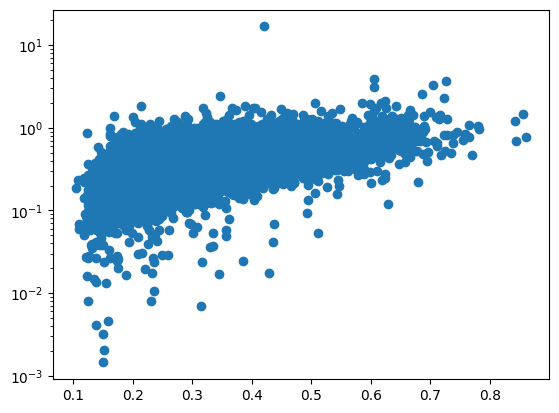

PearsonRResult(statistic=0.49433315555697577, pvalue=0.0)

In [344]:
import matplotlib.pyplot as plt
#plt.scatter(bestPredictions[:,0], yTest[:,0])
plt.scatter(bestPredictions[:,0], yVal[:,0])
#plt.xscale("log")
plt.yscale("log")
plt.show()

from scipy.stats import pearsonr
#pearsonr(bestPredictions[:,0], yTest[:,0])
pearsonr(bestPredictions[:,0], yVal[:,0])

In [42]:
# resPath = "C:\\Users\RobinForMLThesis\\OneDrive - Hanken Svenska handelshogskolan\\Master's_Thesis\\DataAnalysis\\resultsPython.csv"

# finalResults = pd.DataFrame(MSEMatrix)
# pd.DataFrame.to_csv(finalResults, resPath)
# #pd.DataFrame.to_csv(finalResults, "resultsPython.csv")

# MSEMatrix.tofile(resPath, sep = ',')

# finalResults

In [495]:
MSEMatrix.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 124 entries, 0 to 6896254
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Model type               124 non-null    object 
 1   Hidden layers            100 non-null    object 
 2   Hidden units             100 non-null    object 
 3   Activation function      100 non-null    object 
 4   Dropout                  100 non-null    object 
 5   L1                       120 non-null    object 
 6   L2                       120 non-null    object 
 7   Batch size               121 non-null    object 
 8   Optimizer                121 non-null    object 
 9   Learning rate            121 non-null    float64
 10  Epochs                   121 non-null    object 
 11  MAE                      3 non-null      float64
 12  MSE                      3 non-null      float64
 13  ModelPointer             121 non-null    object 
 14  loss                  

In [511]:
import math
formattedMSEMatrix = MSEMatrix.drop(["ModelPointer"], axis=1)

if target == ["returns"] or target == ["volatility"]:
    formattedMSEMatrix = formattedMSEMatrix.sort_values(by=["MAE", "MSE", "loss"], axis = 0)
else:
    formattedMSEMatrix = formattedMSEMatrix.sort_values(by=["accuracy"], axis = 0, ascending=False)
#formattedMSEMatrix[["L1", "L2"]] = round(formattedMSEMatrix[["L1", "L2"]], 1)
#formattedMSEMatrix = round(formattedMSEMatrix, 1)

def RobRound(x): 
    if(x==None or math.isnan(x)): return None
    else: return np.format_float_positional(x, precision=2, unique=False, fractional=False, trim='-', min_digits=None)

def RobRoundFrac(x): 
    if(x==None or math.isnan(x)): return None
    else: return np.format_float_positional(x, precision=3, unique=False, fractional=True, min_digits=None)

def RobRoundTime(x): 
    if(x==None or math.isnan(x)): return None
    else: return np.format_float_positional(x, precision=2, unique=False, fractional=True, min_digits=None)


formattedMSEMatrix["L1"] = formattedMSEMatrix["L1"].apply(lambda x: RobRound(x))
formattedMSEMatrix["L2"] = formattedMSEMatrix["L2"].apply(lambda x: RobRound(x))
formattedMSEMatrix["MSE"] = formattedMSEMatrix["MSE"].apply(lambda x: RobRoundFrac(x))
formattedMSEMatrix["MAE"] = formattedMSEMatrix["MAE"].apply(lambda x: RobRoundFrac(x))
formattedMSEMatrix["loss"] = formattedMSEMatrix["loss"].apply(lambda x: RobRoundFrac(x))
formattedMSEMatrix["accuracy"] = formattedMSEMatrix["accuracy"].apply(lambda x: RobRoundFrac(x))
formattedMSEMatrix["Learning rate"] = formattedMSEMatrix["Learning rate"].apply(lambda x: RobRound(x))
formattedMSEMatrix["Training Time (minutes)"] = formattedMSEMatrix["Training Time (minutes)"].apply(lambda x: RobRoundTime(float(x)))

#formattedMSEMatrix = formattedMSEMatrix.fillna(value=np.nan)

from datetime import datetime
now = datetime.now().strftime("%d-%m-%Y_%H%M")
modelComparisonPathHTML = "Results//2Class//ModelComparison_" + str(now) + ".html"
modelComparisonPathCSV = "Results//2Class//ModelComparison_" + str(now) + ".csv"

#pd.DataFrame.to_csv(MSEMatrix, "Results/ModelComparison.csv", index=False)
#pd.DataFrame.to_excel(MSEMatrix, "Results/ModelComparison.xlsx")
pd.DataFrame.to_html(formattedMSEMatrix, modelComparisonPathHTML, index=False)
pd.DataFrame.to_csv(formattedMSEMatrix, modelComparisonPathCSV, index=False)

In [509]:
np.format_float_positional(np.NaN, precision=2)

'nan'

In [494]:
formattedMSEMatrix.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 124 entries, 0 to 2142870
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Model type               124 non-null    object 
 1   Hidden layers            100 non-null    float64
 2   Hidden units             100 non-null    float64
 3   Activation function      100 non-null    object 
 4   Dropout                  100 non-null    float64
 5   L1                       120 non-null    object 
 6   L2                       120 non-null    object 
 7   Batch size               121 non-null    float64
 8   Optimizer                121 non-null    object 
 9   Learning rate            124 non-null    object 
 10  Epochs                   121 non-null    float64
 11  MAE                      124 non-null    object 
 12  MSE                      124 non-null    object 
 13  loss                     124 non-null    object 
 14  accuracy              

In [244]:
MSEMatrixContinuation = pd.read_csv(modelComparisonPathCSV)

In [ ]:
#Variable importance



# VarImpData = np.asarray(xRatioData).astype('float32')
# VarImpData = scipy.stats.mstats.winsorize(VarImpData, limits = (0.05, 0.95))
# VarImpData = scaler.fit_transform(VarImpData)

rows = len(finalResults["ModelPointer"])
cols = len(xVal.columns)
zeroedXVal = np.array(xVal)

rows = 5

#VarImpResults = pd.DataFrame(columns = X.columns)
VarImpArray = np.empty((rows, cols), dtype=float, order='C')
normalMSEArray = np.empty((rows, 1), dtype=float, order='C')

for row in range(0, rows):
    
    model = finalResults["ModelPointer"][row]

    loss = model.evaluate(zeroedXVal, yVal, batch_size=128, verbose = 0)
    loss = [x for x in loss]
    normalMSE = loss[0]
    normalMSEArray[row, 0] = normalMSE

    for col in range(0, cols):

        # print("\n")
        # print("Model ", str(row+1), " out of ", str(rows))
        # print("Variable ", str(col+1), " out of ", str(cols))

        zeroedXVal[:,col] = 0
        #VarImpData[col].values[:] = 0
        loss = model.evaluate(zeroedXVal, yVal, batch_size=128, verbose = 0)
        zeroedXVal[:,col] = np.array(xVal[xVal.columns[col]])

        try:
            loss = [x for x in loss]
            VarImpMSE = loss[0]
            VarImpArray[row, col] = VarImpMSE
            print("Loss is %s on model %s variable %s" % (loss, row, col))
        except:     
            print("RobError!: Loss is %s on model %s variable %s" % (loss, row, col))



VarImpResults = pd.DataFrame(VarImpArray, columns = xVal.columns)
normalMSEArray = pd.DataFrame(normalMSEArray, columns = ["AllVariables"])

VarImpResults = pd.concat([VarImpResults, normalMSEArray], axis=1)

VarImpMean = VarImpResults.mean(axis=0)



In [ ]:
import pandas as pd
variableDescriptions = pd.read_excel(
    "Data/CompustatVariableDescriptions/VariableDescriptions.xlsx",
    header=2,
    index_col="N")

variableDescriptions["Variable Name"] = [n.strip() for n in variableDescriptions["Variable Name"]]

import re
variableDescriptions["ShortDescr"] = variableDescriptions["Description"].apply(lambda x : re.sub(r".*-- ", "", x))
#variableDescriptions["ShortDescr"] = variableDescriptions["ShortDescr"].apply(lambda x : re.sub(r" >.*", "", x))
#variableDescriptions["ShortDescr"] = variableDescriptions["ShortDescr"].apply(lambda x : re.sub(r" -.*", "", x))

variableDescriptions["ShortDescr"]

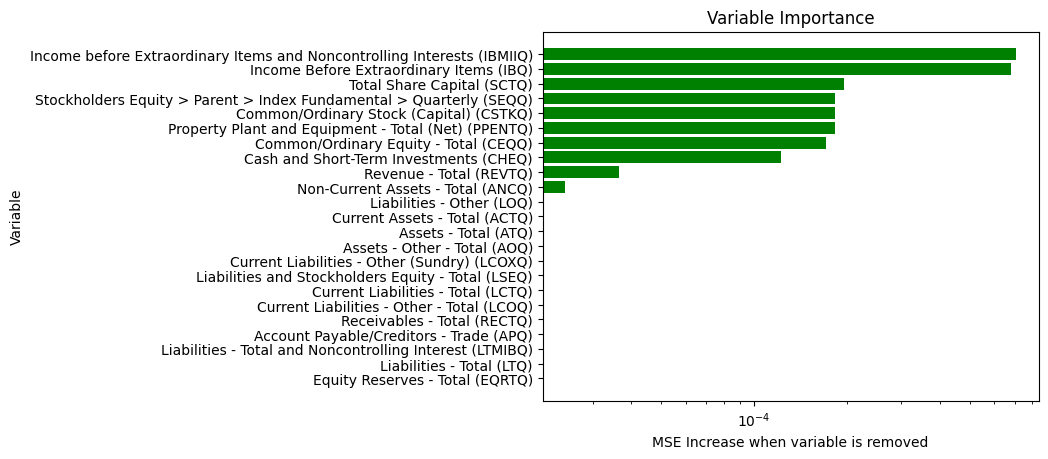

In [123]:
VarImpMean = VarImpResults.mean(axis=0)
VarImpMeanSorted = VarImpMean.sort_values(ascending=False)

VarImpMeanSorted = VarImpMeanSorted - VarImpMean["AllVariables"]

VarImpMeanSorted = VarImpMeanSorted.rename("MSE Increase")
VarImpMeanSorted.index = VarImpMeanSorted.index.str.upper()

VarImpMeanSorted = pd.merge(
    VarImpMeanSorted, variableDescriptions, left_index=True, right_on="Variable Name")

pd.DataFrame.to_html(VarImpMeanSorted, "Results/VariableImportance8.html", index=False)

VarImpMeanBest = VarImpMeanSorted[1:25]
# VarImpMeanScaled = VarImpMeanBest - VarImpMeanBest.mean()

import matplotlib.pyplot as plt

plt.barh(
    #VarImpMeanBest["Variable Name"], VarImpMeanBest["MSE Increase"], log=True, color="green")  # , height = 0.4)#, width, bottom=VarImpMean.min(), align)
    VarImpMeanBest["ShortDescr"], VarImpMeanBest["MSE Increase"], log=True, color="green")  # , height = 0.4)#, width, bottom=VarImpMean.min(), align)

plt.gca().invert_yaxis()  # labels read top-to-bottom


plt.title("Variable Importance")
plt.ylabel("Variable")
plt.xlabel("MSE Increase when variable is removed")
# plt.legend(['train', 'test'], loc='upper left')


from datetime import datetime
now = datetime.now().strftime("%d-%m-%Y_%H%M")
variableImportancePath = "Results/VariableImportance_" + str(now) + ".png"

plt.savefig(variableImportancePath)
# from matplotlib.ticker import ScalarFormatter
# plt.gca().xaxis.set_major_formatter(ScalarFormatter())
plt.show()


Epoch 1/300
676/676 - 4s - loss: 1987.6479 - mean_absolute_error: 20.3377 - val_loss: 2673.2761 - val_mean_absolute_error: 21.5853 - 4s/epoch - 5ms/step
Epoch 2/300
676/676 - 2s - loss: 1984.8063 - mean_absolute_error: 20.4015 - val_loss: 2667.5227 - val_mean_absolute_error: 21.5985 - 2s/epoch - 3ms/step
Epoch 3/300
676/676 - 3s - loss: 1982.5377 - mean_absolute_error: 20.4730 - val_loss: 2662.2070 - val_mean_absolute_error: 21.6164 - 3s/epoch - 4ms/step
Epoch 4/300
676/676 - 3s - loss: 1981.9677 - mean_absolute_error: 20.4623 - val_loss: 2662.0515 - val_mean_absolute_error: 21.6161 - 3s/epoch - 4ms/step
Epoch 5/300
676/676 - 2s - loss: 1979.8287 - mean_absolute_error: 20.4972 - val_loss: 2655.8665 - val_mean_absolute_error: 21.6415 - 2s/epoch - 4ms/step
Epoch 6/300
676/676 - 3s - loss: 1979.3455 - mean_absolute_error: 20.5257 - val_loss: 2657.9641 - val_mean_absolute_error: 21.6281 - 3s/epoch - 4ms/step
Epoch 7/300
676/676 - 2s - loss: 1978.1211 - mean_absolute_error: 20.5215 - val_lo

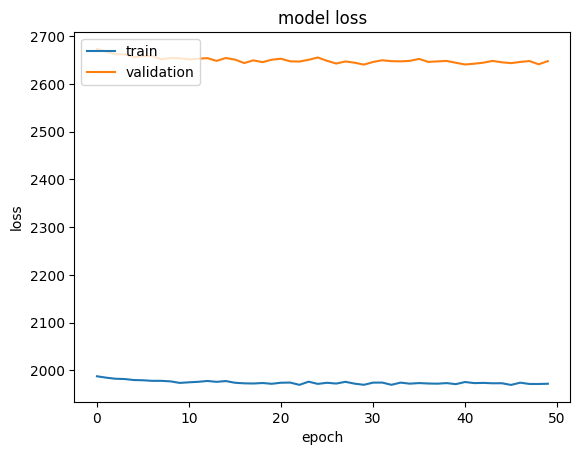

In [48]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt


bestModel = keras.models.load_model('Results/BestKerasModel8')
#plot(model)


bestModel = tf.keras.Sequential()
bestModel.add(tf.keras.layers.Dense(units=5, activation="relu"))
bestModel.add(tf.keras.layers.Dropout(0.3))
bestModel.add(tf.keras.layers.Dense(units=5, activation="relu"))
bestModel.add(tf.keras.layers.Dropout(0.3))
bestModel.add(tf.keras.layers.Dense(units=5, activation="relu"))
bestModel.add(tf.keras.layers.Dropout(0.3))
bestModel.add(tf.keras.layers.Dense(units=5, activation="relu"))
bestModel.add(tf.keras.layers.Dropout(0.3))
bestModel.add(tf.keras.layers.Dense(units=1))

callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=20, verbose=1, restore_best_weights=True)


bestModel.reset_states()


compiledBestModel = bestModel.compile(optimizer="RMSprop",  # Adam(learning_rate=0.0001) #RMSprop #sgd
                                      loss="MeanSquaredError",  # 'tf.keras.losses.MeanSquaredError()',
                                      metrics=['MeanAbsoluteError'])

bestModel.reset_states()



#xTrainValiPooled = scaled_X[:validationSize,:]
xTrainValiPooled = X.loc[X["Split"]=="Validation", :]
#yTrainValiPooled = Y[:validationSize]
yTrainValiPooled = Y[Y["Split"]=="Validation"]
history = bestModel.fit(x=xTrainValiPooled, y=yTrainValiPooled, batch_size=32,
                        epochs=300, verbose=2, validation_data=(xTest, yTest), callbacks = [callback])



from datetime import datetime
now = datetime.now().strftime("%d-%m-%Y_%H%M")
learningCurvePath = "Results/LearningCurve_" + str(now) + ".png"

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig(learningCurvePath)
plt.show()


# # summarize history for accuracy
# plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()




In [77]:
#Visualize network

bestModel = keras.models.load_model('Results/BestKerasModel8')

import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin/'

import pydot
import pydotplus
import graphviz

from ann_visualizer.visualize import ann_viz


# from datetime import datetime
# now = datetime.now().strftime("%d-%m-%Y_%H%M")
# learningCurvePath = "Results/LearningCurve_" + str(now) + ".png"

ann_viz(bestModel, view=True, filename="Results/BestModel8", title="Best Model Visualized")




In [50]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

bestModel = keras.models.load_model('Results/BestKerasModel7')




#Print summary
modelSummary = bestModel.summary()
print(modelSummary)


# from datetime import datetime
# now = datetime.now().strftime("%d-%m-%Y_%H%M")
# learningCurvePath = "Results/LearningCurve_" + str(now) + ".png"

with open('Results/BestModelSummary7.html', 'w') as f:

    bestModel.summary(print_fn=lambda x: f.write(x + '\n'))




# import os
# os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin/'

# import pydot
# import pydotplus
# import graphviz

# tf.keras.utils.plot_model(
#     bestModel,
#     to_file="Results/BestModel.png",
#     show_shapes=True,
#     show_dtype=False,
#     show_layer_names=True,
#     rankdir="LR",
#     expand_nested=False,
#     dpi=96,
#     layer_range=None,
#     show_layer_activations=True,
# )



#pred = model.predict(xWinVal, batch_size=128)

#plt.scatter(pred, yVal)
#pred

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_13 (Dense)            (None, 1)                 86        
                                                                 
Total params: 86
Trainable params: 86
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
#ynew = model.predict_classes(Xnew)

In [ ]:
#(Geron 2019, 76, 320)

#from sklearn import RandomizedSearchCV, GridSearchCV



#(Geron 2019, 76)
from sklearn.model_selection import GridSearchCV
param_grid = [
{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
{'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
]
forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
scoring='neg_mean_squared_error',
return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)



grid_search.best_params_

grid_search.best_estimator_

cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)





#(Geron 2019, 320)


def build_model(n_hidden=1, n_neurons=30, learning_rate=3e-3, input_shape=[8]):
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape=input_shape))
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation="relu"))
        model.add(keras.layers.Dense(1))
    optimizer = keras.optimizers.SGD(lr=learning_rate)
    model.compile(loss="mse", optimizer=optimizer)
    return model


keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)


keras_reg.fit(X_train, y_train, epochs=100,
validation_data=(X_valid, y_valid),
callbacks=[keras.callbacks.EarlyStopping(patience=10)])
mse_test = keras_reg.score(X_test, y_test)
y_pred = keras_reg.predict(X_new)




from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV
param_distribs = {
    "n_hidden": [0, 1, 2, 3],
    "n_neurons": np.arange(1, 100),
    "learning_rate": reciprocal(3e-4, 3e-2),
}
rnd_search_cv = RandomizedSearchCV(keras_reg, param_distribs, n_iter=10, cv=3)
rnd_search_cv.fit(X_train, y_train, epochs=100,
validation_data=(X_valid, y_valid),
callbacks=[keras.callbacks.EarlyStopping(patience=10)])


rnd_search_cv.best_params_
rnd_search_cv.best_score_
model = rnd_search_cv.best_estimator_.model








#Chollet: DL for Python
import kerastuner as kt





#strategy = tf.distribute.MirroredStrategy()





#If your search process crashes, you can always restart it—just specify overwrite=False in the tuner so that it can resume from the trial logs stored on disk.




